# Filter for specific tidal frequencies

In [1]:
# import modules

import xarray as xr
import datetime as dt
import math
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as pldates
import matplotlib.colors as colors
import scipy.signal as sig
import numpy as np
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
for i in range(2):
    %matplotlib notebook

In [2]:
# import data

year = 2013
ds = xr.open_dataset(f'../../../Data/tide/tofino_tide_{year}.nc')
    
print(ds)

<xarray.Dataset>
Dimensions:  (time: 8684)
Coordinates:
  * time     (time) datetime64[ns] 2013-01-01 2013-01-01T01:00:00 ... 2014-01-01
Data variables:
    tide     (time) float64 ...
Attributes:
    description:  Tide data from Tofino CHS, 2013.
    units:        metres above chart datum, numpy.datetime64


## Spectral method

In [3]:
# remove mean

tidem = ds.tide - np.nanmean(ds.tide)

In [4]:
# spectrogram of tide

fs = 2.7777e-4
nps = 256
overlap = 0.9*nps
win = 'hann'

tide_f, tide_t, tide_Sxx = sig.spectrogram(tidem, fs=fs, window=win, \
                                                            nperseg = nps, noverlap = overlap, return_onesided=True)

# convert spectro_t to datetime for x-axis on plots for PSD
spectro_t4 = tide_t*fs
spectro_time_len = len(spectro_t4)
spectro_time_axis = np.zeros([spectro_time_len],dtype='datetime64[s]')
for k in range(spectro_time_len):
    j = int(spectro_t4[k])
    spectro_time_axis[k] = ds.time[j].values
time_axis = spectro_time_axis

<IPython.core.display.Javascript object>


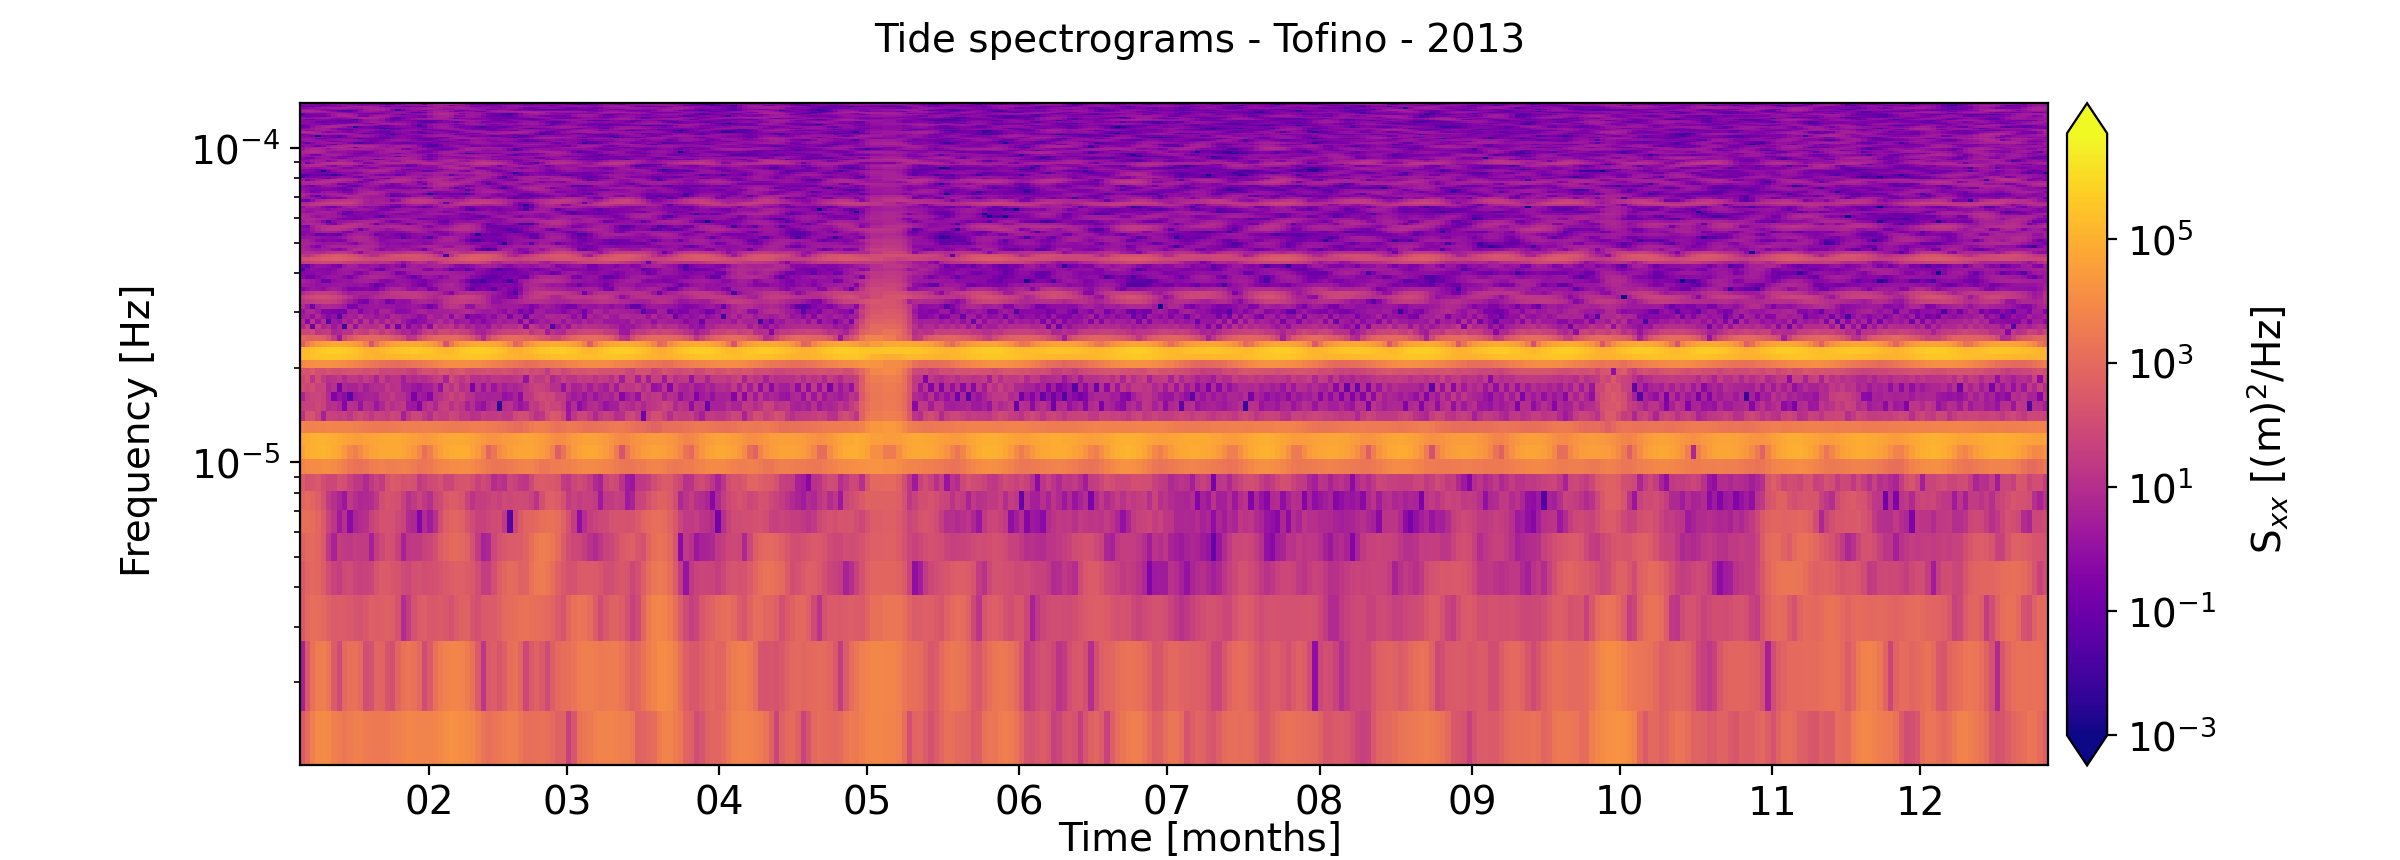

In [5]:
# plot spectrogram

start_date = ds.time[0].values
end_date = ds.time[0].values

fig, ax0 = plt.subplots(1, 1, figsize=(12,4.3))
fig.text(0.5, 0.94, f'Tide spectrograms - Tofino - {year}', ha='center', fontsize=14)
fig.text(0.05, 0.5, 'Frequency [Hz]', va='center', rotation='vertical', fontsize=14)
fig.text(0.935, 0.5, 'S$_{xx}$ [(m)$^2$/Hz]', va='center', rotation='vertical', fontsize=14)
fig.text(0.5, 0.01, f'Time [months]', ha='center',fontsize=14)

vmin = 1e-3
vmax = 5e6

im0 = ax0.pcolormesh(time_axis, tide_f, tide_Sxx, rasterized=True, \
                    norm=colors.LogNorm(vmin=vmin, vmax=vmax), cmap='plasma',shading='auto')  

cbar0 = fig.colorbar(im0, ax=ax0, fraction=0.05, pad=0.01, aspect=15, extend='both')   
cbar0.ax.tick_params(labelsize=14)

ax0.patch.set_facecolor('grey')

ax0.set_yscale('log')
ax0.set_ylim(tide_f[1],tide_f[-1])
date_form = pldates.DateFormatter("%m")
ax0.xaxis.set_major_formatter(date_form)
#ax0.set_xlim(start_date,end_date)
ax0.tick_params(labelsize=14)

plt.show()

plt.savefig(fname=f'./tide_spectro_{year}.pdf',format='pdf')

In [6]:
# filter tides

band = 'Semidiurnal'   # Diurnal or Semidiurnal

if band == 'Diurnal':
    low_f = 10
    high_f = 13
    freqs = tide_f[low_f:high_f]
elif band == 'Semidiurnal':
    low_f = 20
    high_f = 23
    freqs = tide_f[low_f:high_f]
    
t = len(time_axis)
tidepower = np.zeros(t)
for i in range(t):
    bandrange = tide_Sxx[low_f:high_f,i]
    tidepower[i] = np.trapz(y=bandrange,x=freqs)

In [7]:
print(freqs)

[2.17007813e-05 2.27858203e-05 2.38708594e-05]


<IPython.core.display.Javascript object>


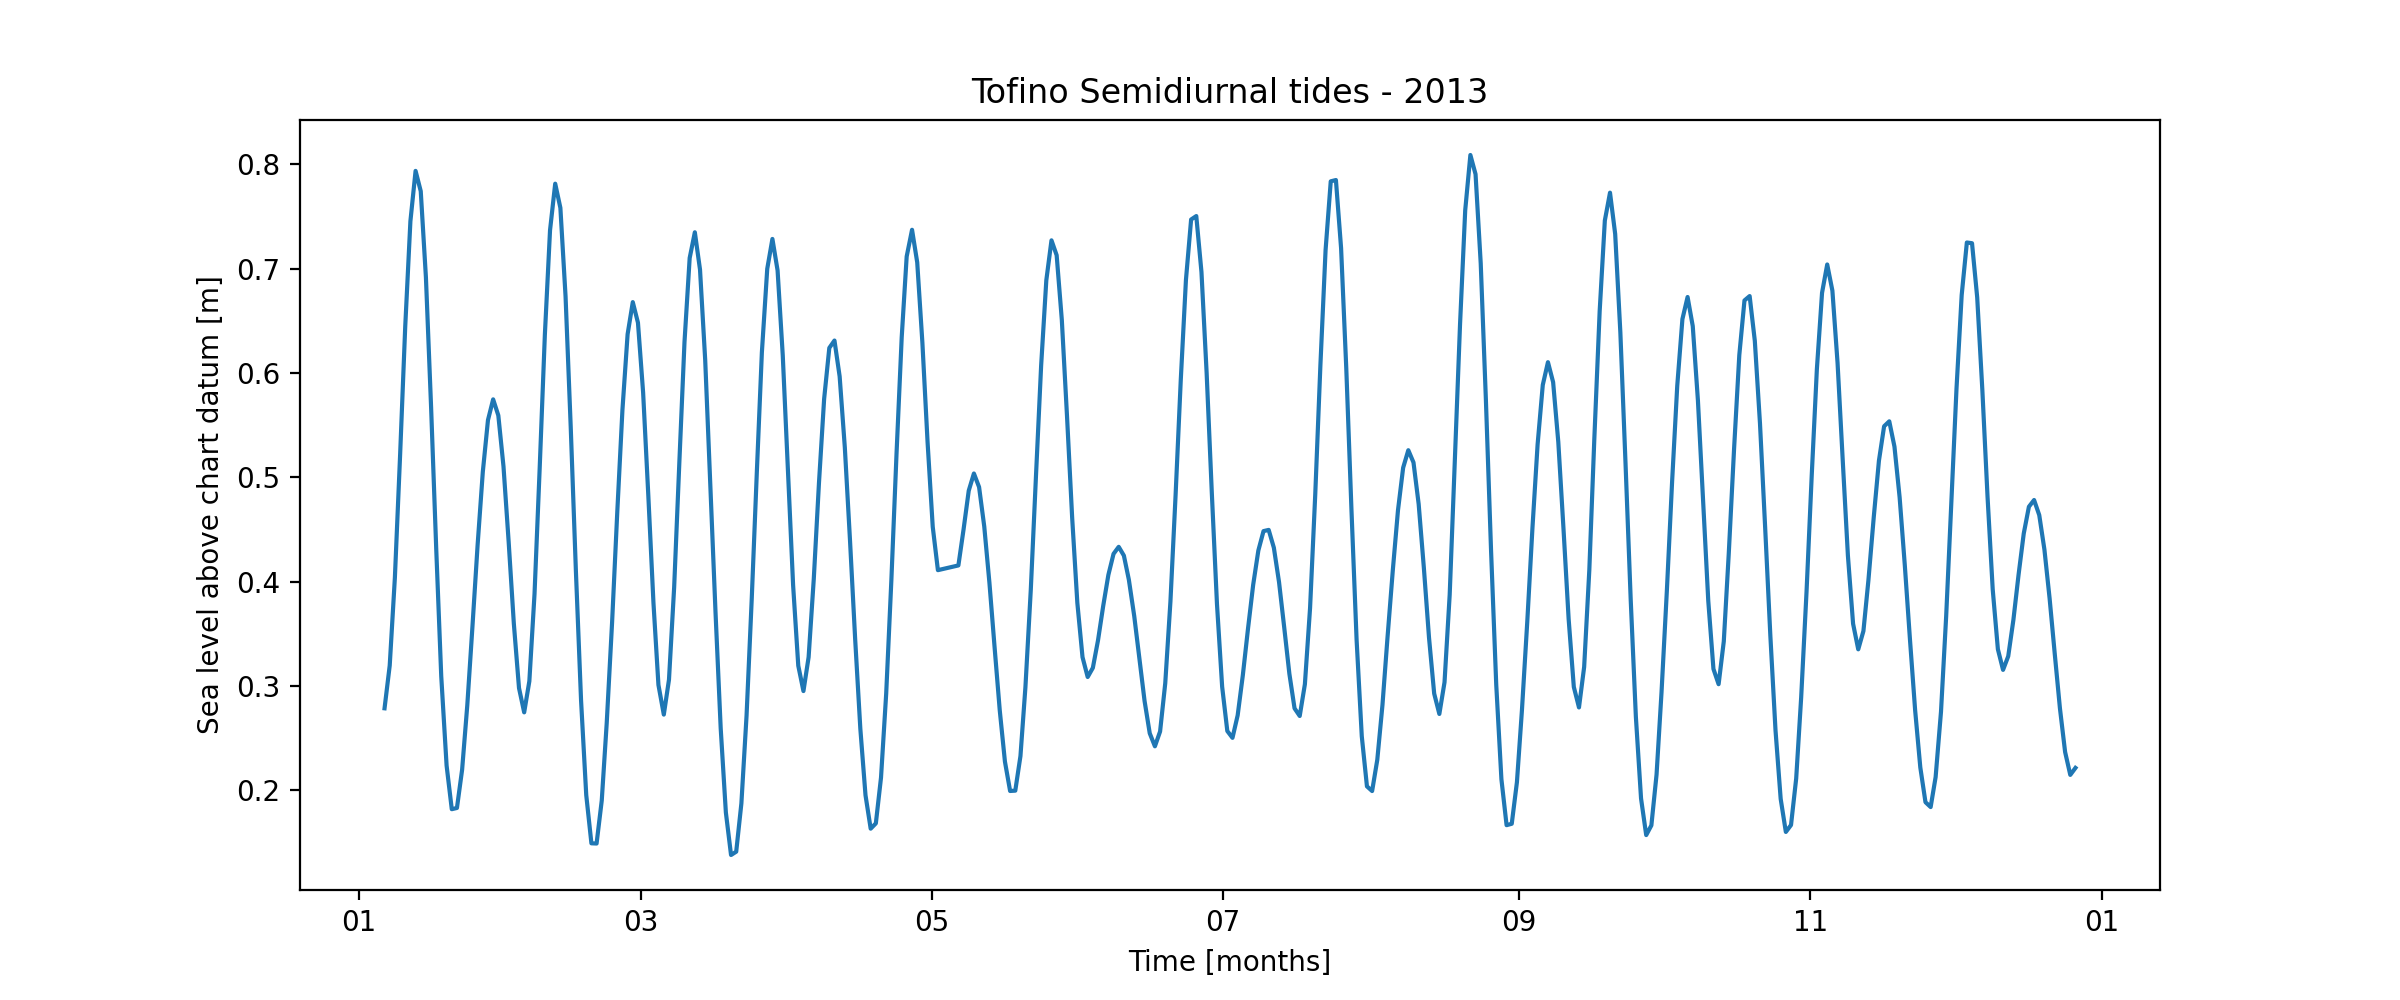

In [8]:
# plot tides

fig,ax = plt.subplots(1,1,figsize=(12,5))
ax.plot(time_axis,tidepower)
date_form = pldates.DateFormatter("%m")
ax.xaxis.set_major_formatter(date_form)
ax.set_xlabel('Time [months]')
ax.set_ylabel('Sea level above chart datum [m]')
ax.set_title(f'Tofino {band} tides - {year}')
plt.show()

plt.savefig(fname=f'./tide_{band}_{year}.pdf',format='pdf')

In [9]:
# save to .nc file

ds_out = xr.Dataset( 
    data_vars=dict(
        tide=(['time'], tidepower),    # tide height data [m]
    ),
    coords=dict(
        time=time_axis,              
    ),
    attrs=dict(
        description=f'Tide data from Tofino CHS, filtered for {band} response.',
        units=['metres amplitude, numpy.datetime64'],
    ),
) 
ds_out.to_netcdf(f'../../../Data/tide/tide_{band}_{year}.nc')